# Scenario

## Scenario 1: Pre Development model, no seasonality

Build the base model as described above without the proposed agricultural activity.
 * Run the model as steady state with no pumping from the town's well.
 * Calculate the flux from the stream to the groundwater
 * Also show a reverse particle track map to identify the source of the water to the stream.
 * Finally, report the water level at the monitoring wells and at the town's well (even though it isn't pumping for this scenario).

# Import

In [1]:
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
%matplotlib inline

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


# Set up the domain

In [2]:
## Discretization in x/y
nrow = 50
ncol = 50

dx = 1000 #width of one grid cell in x-dir (m)
dy = 1000 #width of one grid cell in y-dir (m)

Lx = ncol * dx #Total length of domain in x
Ly = nrow * dy #Total length of domain in y

## Discretization in z
nlay = 3
ztop=np.genfromtxt('base_model_elevs.csv',delimiter=',',dtype=float) #import "dem"
ztop[0,0]=125 #is this the missing initial value

zbot=np.zeros((nlay,nrow,ncol)) #bottom of domain is zero
zbot[1,:,:]=40 #bottom of middle layer
zbot[0,:,:]=45 #bottom of top layer

##Static hydrogeologic variables 
n = 0.1
Sy = 0.1
Ss = 1e-4
hka = 10 #this is the horizontal k for top, middle and bottom 
vka = 10 #vertical k for horizontal k for top, bottom, and left 20 cols for middle
vka_mid = 0.0001 #vertical k for right 30 cols

## Make a arrays for the K values
#Set horizontal K
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = hka                 # assign the original value to the entire array

#set vertical K
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = vka                   # assign the original value to the entire array
Kz[1,:,20:] = vka_mid                 #Replace the K in the middle layer with the lower value


nper=1
steady=[True]

##Setting no flow triangles
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#Setting up Recharge
recharge_zone = np.zeros((1,nrow,ncol)) # define an array of zeros the size of the model grid

rech1 = 4e-5 # m/day
rech_llxy = [0,0]  # lower left xy coords
rech_urxy = [15000,50000] # upper right xy coords
##convert to rows and columns
rech_rowll = int(np.floor((nrow-1)-(rech_llxy[1]/dy))) #convert the y location to a row
rech_colll=int(np.floor(rech_llxy[0]/dx))          #convert the x location to a column
rech_rowur = int(np.floor((nrow)-(rech_urxy[1]/dy))) #convert the y location to a row
rech_colur=int(np.floor(rech_urxy[0]/dx))          #convert the x location to a column
#print(rech_colll, rech_rowll, rech_colur, rech_rowur)

recharge_zone[0,rech_rowur:rech_rowll, rech_colll:rech_colur] = rech1


# Setting up ET
ET_zone = np.zeros((1,nrow,ncol))#ET in left half of domain is zero
ET_right = 1e-5 #m/day ET over right of domain
ET_rip =5e-5 #ET in riparian area
extinction_depth = 10 #10m everywhere

ET_right_llxy = [25000,0] #lower left corner xy for right half ET zone
ET_right_urxy = [50000,50000]
##convert to rows and columns
ET_right_rowll = int(np.floor((nrow-1)-(ET_right_llxy[1]/dy))) #convert the y location to a row
ET_right_colll=int(np.floor(ET_right_llxy[0]/dx))          #convert the x location to a column
ET_right_rowur = int(np.floor((nrow)-(ET_right_urxy[1]/dy))) #convert the y location to a row
ET_right_colur=int(np.floor(ET_right_urxy[0]/dx))          #convert the x location to a column
print(ET_right_colll, ET_right_rowll, ET_right_colur, ET_right_rowur)

ET_zone[0,ET_right_rowur:ET_right_rowll, ET_right_colll:ET_right_colur] = ET_right


ET_rip_llxy = [0,23000]#lower left corner xy for riparian strip
ET_rip_urxy = [50000,29000]
##convert to rows and columns
ET_rip_rowll = int(np.floor((nrow-1)-(ET_rip_llxy[1]/dy))) #convert the y location to a row
ET_rip_colll=int(np.floor(ET_rip_llxy[0]/dx))          #convert the x location to a column
ET_rip_rowur = int(np.floor((nrow)-(ET_rip_urxy[1]/dy))) #convert the y location to a row
ET_rip_colur=int(np.floor(ET_rip_urxy[0]/dx))          #convert the x location to a column
print(ET_rip_colll, ET_rip_rowll, ET_rip_colur, ET_rip_rowur)

ET_zone[0,ET_rip_rowur:ET_rip_rowll, ET_rip_colll:ET_rip_colur] = ET_rip


# Setting up well
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = 0 # m^3/d         -3000 irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = [2,well_1_row,well_1_col] #Well loc (layer, row, column)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = [0,well_2_row,well_2_col] #Well loc (layer, row, column)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
MW1_col=np.floor(MW1_xy[0]/dx-1) 
MW1_loc = [0,MW1_row,MW1_col] 

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = [0,MW2_row,MW2_col] 

#CHD package things
    #assign heads at start and end of stress period
strt_head = 70
# end_head = 70
#     #create list to hold stress period constant head boundary condition cells
# bound_sp1 = []
#     #assign constant head boundary cells on the left and right boundaries
# for lay in range(nlay):
#     for row in range(nrow):
#         #bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
#         bound_sp1.append([lay,row,ncol-1,strt_head,end_head]) #assigns all cells in last col
#create dictionary with stress period data
# chd_spd={0: bound_sp1}
    
# setting up river package
# riv_sp1=[]
# k_rivbott=1000 
# sed_thick=1 
# cond=k_rivbott*(dy)*(dx)/(sed_thick) 
# r_bott=ztop[26,:]-1
# r_stage=r_bott+0.5 
# for i in range(nrow):
#     riv_sp1.append([0,26,i,r_stage[i]+1,cond,r_bott[i]])
# riv_spd={0:riv_sp1}
# print(r_stage)

25 49 50 0
0 26 50 21


# Setup and Run MODFLOW for Scenario 1

In [3]:
#Initialize the model
modelname = "Scenario_1"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #as 1 everywhere 
H_init[:, :, ncol-1] = strt_head    #right boundary to 70
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=recharge_zone, ipakcb=53)     #create rch object

#ET:
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Setting up Wells

well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)
well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)
Mwell_1 = [i for i in MW1_loc] + [0]
print("Monitoring Well 1 [layer, row, column, flux]: \n", Mwell_1)
Mwell_2 = [i for i in MW2_loc] + [0]
print("Monitoring Well 2 [layer, row, column, flux]: \n", Mwell_2)


wel_spd = {0: [well_1, well_2, Mwell_1, Mwell_2]}
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    
#Setup flopy CHD object
# chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

#attach river package
# riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)

#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, 0]
Monitoring Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, 0]
Monitoring Well 2 [layer, row, column, flux]: 
 [0, 36.0, 11.0, 0]
FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16 12:58:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16 12:58:59
 Elapsed run time:  0.045 Seconds

  Normal termination of simulation


# Check: Plotting the domain

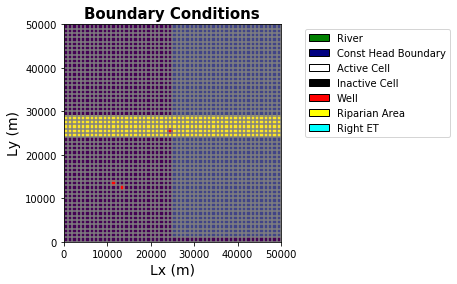

In [4]:
#CHECK BOUNDARY CONDITIONS
#use flopy to plot grid, ibound, rivers, and general head boundaries
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

ET = modelmap.plot_array(ET_zone)
#recharge = modelmap.plot_array(recharge_zone)
# riv_plot = modelmap.plot_bc(ftype='RIV')
# chd_plot = modelmap.plot_bc(ftype='CHD')
wel_plot = modelmap.plot_bc(ftype='WEL')

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                   mp.patches.Patch(color='Yellow',label='Riparian Area',ec='black'),
                   mp.patches.Patch(color='cyan',label='Right ET',ec='black')],
                   bbox_to_anchor=(1.8,1.0))


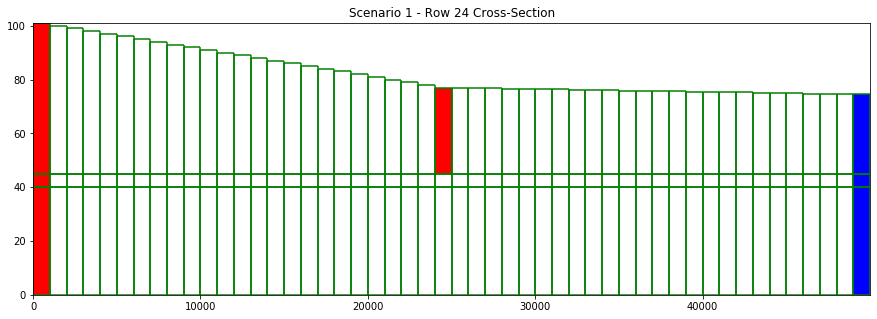

In [5]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Scenario 1 - Row 24 Cross-Section')

# Scenario 2: Pre-developlment with Seasonality

Build the base model as described above without proposed agricultural activity 

Run the model as transient for 25 years with no pumping from the town's well. Recharge occurs at a constant rate all year, but ET takes place from April through September (inclusive) at the rate given in the problem description.

How long does it take for the model to reach a cyclical steady state (annual variations, but no trends)? Use monthly water levels at the monitoring wells to support your conclusion. This is the required 'burn in' time of your model.

### Setting up seasonality

In [6]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 182       # Length of stress period 1 in days, October-March, no ET
sp2_len = 183      # Length of stress period 2 in days. April - September, regular ET
sim_years = 25       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start
#here the total is (25*2)+1 = 51 stress periods
print (nper)
#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
steady[0] = True    # initial stress period is steady-state or true
print(steady)
#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#25 repeating sets of the two stress periods
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1
nstp[0]=1 #for the steady state solution we just want one output
print("Number of Steps", nstp)

51
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Period lengths [ 10 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182
 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182
 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183]
Number of Steps [  1 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182
 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183 182
 183 182 183 182 183 182 183 182 183 182 183 182 183 182 183]


### Setting up seasonal ET

In [7]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET[p] = ET_zone
    if p % 2 != 0:
        ET[p]=ET_zone*0
    else: 
        ET[p] = ET_zone


## Set up and run scenario 2

In [8]:
#Initialize the model
modelname = "Scenario_2"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #as 1 everywhere 
H_init[:, :, ncol-1] = strt_head    #right boundary to 70
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
R = {}                                             # create empty dictionary for recharge fluxes
for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
    R[p]=recharge_zone

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=R, ipakcb=53)     #create rch object


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 


#Setting up Wells
well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)
well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)
Mwell_1 = [i for i in MW1_loc] + [0]
print("Monitoring Well 1 [layer, row, column, flux]: \n", Mwell_1)
Mwell_2 = [i for i in MW2_loc] + [0]
print("Monitoring Well 2 [layer, row, column, flux]: \n", Mwell_2)

wel_spd = {}  
for p in range(0,nper):                  
    wel_spd[p]=[well_1, well_2, Mwell_1, Mwell_2]

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    
#Setup flopy CHD object
# chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

#attach river package
# riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)


#Output control - OC 
oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)

#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, 0]
Monitoring Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, 0]
Monitoring Well 2 [layer, row, column, flux]: 
 [0, 36.0, 11.0, 0]
FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16 12:59:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solvi

 Solving:  Stress period:     2    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   124    Ground-Wa

 Solving:  Stress period:     3    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    52    Ground-Wa

 Solving:  Stress period:     3    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   174    Ground-Wa

 Solving:  Stress period:     4    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   119    Ground-Wa

 Solving:  Stress period:     5    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    66    Ground-Wa

 Solving:  Stress period:     5    Time step:   181    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   182    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   183    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    10    Ground-Wa

 Solving:  Stress period:     6    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   135    Ground-Wa

 Solving:  Stress period:     7    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    65    Ground-Wa

 Solving:  Stress period:     7    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   181    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   182    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   183    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     4    Ground-Wa

 Solving:  Stress period:     8    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   127    Ground-Wa

 Solving:  Stress period:     9    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    64    Ground-Wa

 Solving:  Stress period:     9    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   178    Ground-Wa

 Solving:  Stress period:    10    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   105    Ground-Wa

 Solving:  Stress period:    11    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    36    Ground-Wa

 Solving:  Stress period:    11    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   153    Ground-Wa

 Solving:  Stress period:    12    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    93    Ground-Wa

 Solving:  Stress period:    13    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    31    Ground-Wa

 Solving:  Stress period:    13    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   155    Ground-Wa

 Solving:  Stress period:    14    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    89    Ground-Wa

 Solving:  Stress period:    15    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    14    Ground-Wa

 Solving:  Stress period:    15    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   139    Ground-Wa

 Solving:  Stress period:    16    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    79    Ground-Wa

 Solving:  Stress period:    16    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   181    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   182    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     5    Ground-Wa

 Solving:  Stress period:    17    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   132    Ground-Wa

 Solving:  Stress period:    18    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    69    Ground-Wa

 Solving:  Stress period:    18    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   180    Ground-Wa

 Solving:  Stress period:    19    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   120    Ground-Wa

 Solving:  Stress period:    20    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    67    Ground-Wa

 Solving:  Stress period:    20    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   179    Ground-Wa

 Solving:  Stress period:    21    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   124    Ground-Wa

 Solving:  Stress period:    22    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    48    Ground-Wa

 Solving:  Stress period:    22    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   158    Ground-Wa

 Solving:  Stress period:    23    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   103    Ground-Wa

 Solving:  Stress period:    24    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    53    Ground-Wa

 Solving:  Stress period:    24    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   164    Ground-Wa

 Solving:  Stress period:    25    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   102    Ground-Wa

 Solving:  Stress period:    26    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    50    Ground-Wa

 Solving:  Stress period:    26    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   160    Ground-Wa

 Solving:  Stress period:    27    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    90    Ground-Wa

 Solving:  Stress period:    28    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    33    Ground-Wa

 Solving:  Stress period:    28    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   166    Ground-Wa

 Solving:  Stress period:    29    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   111    Ground-Wa

 Solving:  Stress period:    30    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    51    Ground-Wa

 Solving:  Stress period:    30    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   164    Ground-Wa

 Solving:  Stress period:    31    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   109    Ground-Wa

 Solving:  Stress period:    32    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    59    Ground-Wa

 Solving:  Stress period:    32    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   171    Ground-Wa

 Solving:  Stress period:    33    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   107    Ground-Wa

 Solving:  Stress period:    34    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    55    Ground-Wa

 Solving:  Stress period:    34    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   165    Ground-Wa

 Solving:  Stress period:    35    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   109    Ground-Wa

 Solving:  Stress period:    36    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    56    Ground-Wa

 Solving:  Stress period:    36    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   163    Ground-Wa

 Solving:  Stress period:    37    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   108    Ground-Wa

 Solving:  Stress period:    38    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    54    Ground-Wa

 Solving:  Stress period:    38    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   164    Ground-Wa

 Solving:  Stress period:    39    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   110    Ground-Wa

 Solving:  Stress period:    40    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    58    Ground-Wa

 Solving:  Stress period:    40    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   168    Ground-Wa

 Solving:  Stress period:    41    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   112    Ground-Wa

 Solving:  Stress period:    42    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    57    Ground-Wa

 Solving:  Stress period:    42    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   170    Ground-Wa

 Solving:  Stress period:    43    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   116    Ground-Wa

 Solving:  Stress period:    44    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    59    Ground-Wa

 Solving:  Stress period:    44    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   171    Ground-Wa

 Solving:  Stress period:    45    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   120    Ground-Wa

 Solving:  Stress period:    46    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    44    Ground-Wa

 Solving:  Stress period:    46    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   157    Ground-Wa

 Solving:  Stress period:    47    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   100    Ground-Wa

 Solving:  Stress period:    48    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    39    Ground-Wa

 Solving:  Stress period:    48    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   151    Ground-Wa

 Solving:  Stress period:    49    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    99    Ground-Wa

 Solving:  Stress period:    50    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    23    Ground-Wa

 Solving:  Stress period:    50    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   154    Ground-Wa

 Solving:  Stress period:    51    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   100    Ground-Wa

# Read in the outputs

In [9]:
modelname = "Scenario_2"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] 
#print(times2)

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per



In [10]:
#print(times)
#print(head['sp10'][0][10])
print(MW1_loc,MW2_loc)
#print(len(head))
#print(headobj)
#print(wel_spd[1][3])
#print(ET[2][0][0])
#print(ET_zone[0,ET_rip_rowur:ET_rip_rowll, ET_rip_colll:ET_rip_colur])

[0, 24.0, 24.0] [0, 36.0, 11.0]


# Plot Head at Monitoring Wells

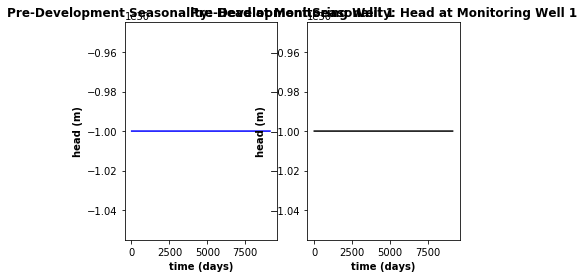

In [11]:
#plot a time series at both monitoring wells
#get time series for a certain cell
#print(well_loc)

cell_id1 = (0,24,24) #cell ID of MW1
cell_id2 = (0,36,11) #cell ID of MW2
time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2


#create plot of MW1
plt.subplot(1, 2, 1)
plt.title("Pre-Development Seasonality: Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.subplot(1, 2, 2)
plt.title("Pre-Development Seasonality: Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series1[:, 1], 'k-') #plot the time series with points at each record
plt.show()

In [13]:
np.set_printoptions(threshold=np.inf)
print((head['sp0'][0]))

[[-9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02
  -9.9999e+02  7.0000e+01]
 [-9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -9.9999e+02 -1.0000e+30
  -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30
  -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30
  -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30
  -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30 -1.0000e+30
  -1.0000e+